# Final Project of Quantum Computation

20195048 Hyunseong Kim

## Problem 1

Solve the following linear system with HHL algorithm

$$\begin{bmatrix}1 & -1/3 \\ -1/3 & 1\end{bmatrix} \mathbf{x} = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

## Problem 2 

Extend the problem 1 result and solve following equation

$$\frac{1}{4}
\begin{bmatrix}
15 & 9 & 5 & -3 \\
9 & 15 & 3 & -5 \\
5 & 3 & 15 & -9 \\
-3 & -5 & -9 & 15\end{bmatrix} \mathbf{x} = 
\frac{1}{2} 
\begin{bmatrix}
1\\
1\\
1\\
1
\end{bmatrix}$$

## Answer

Since the matrix already a Hermit matrix, the calculation does not require a conversion. Before we implement HHL. Let us see the exact solutions of the each system.

### Exact solutions

In [1]:
from IPython.display import display, Math

In [2]:
import sympy as sp
import numpy as np
from sympy.printing.mathml import mathml
#sp.init_printing(use_unicode=True) # allow LaTeX printing


In [3]:
scale1 = 3
A1 = sp.Matrix([[3, -1], [-1, 3]])/scale1
b1 = sp.Matrix([[0], [1]])
scale2 = 4
A2 = sp.Matrix(
    [
        [15, 9, 5, -3], 
        [9, 15, 3, -5],
        [5, 3, 15, -9],
        [-3, -5, -9, 15]])/scale2
b2 = sp.Matrix(4*[[2]])/scale2

A1_np = np.array(A1).astype(complex)
A2_np = np.array(A2).astype(complex)

In [4]:
display(Math(sp.latex(A1)))
display(Math(f"$det(A_1): {A1.det()}$",))
display(Math("$\mathbf{x}: " + sp.latex(A1.solve(b1).T)))
display(Math(sp.latex(A2)))
display(Math(f"$det(A_2): {A2.det()}$",))
display(Math("$\mathbf{x}: " + sp.latex(A2.solve(b2).T)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# A2 
display(A2.eigenvals())
display(Math(sp.latex(A2.eigenvects())))

{8: 1, 4: 1, 2: 1, 1: 1}

<IPython.core.display.Math object>

In [6]:
evlist = (e1, e2, e3 ,e4) = [np.array(c[0]).astype(complex) for (a, b, c) in A2.eigenvects()]
eval2 = list(A2.eigenvals().keys())
(eval2).reverse()
eval2

[1, 2, 4, 8]

## System configuration

Eigenvalues and eigenvectos of each systems

* $\{\lambda _i\}_{A_1} = \{ \frac{2}{3}, \frac{4}{3}\}$
* $\{\lambda _i\}_{A_2} = \{ \frac{1}{4}, \frac{2}{4}, \frac{4}{4}, \frac{8}{4}\}$

then, the desired scaled eigenvalues and the scale factors are 

$$\tilde{\lambda} = N \frac{\lambda }{2 \pi} t $$

* $\{\tilde{\lambda}_i\}_{A_1} = \{ 1, 2\}$
* $\{\tilde{\lambda}_i\}_{A_2} = \{ 1, 2, 4, 8\}$
* $t_1 = \frac{3}{4} \pi $
* $t_2 = \frac{1}{8} \pi $


In [408]:
t1 = 3/4 * np.pi
t2 = 1/8 * np.pi

### Implementation of HHL algorithm

Major steps of HHL algorithm

3 registers required: ancilla, main-register, b-register.

1. State preparation: Encoding $|b\rangle$ vector to the register, amplitude encoding(b).
2. Quantum Phase estimation(main, b).
3. Ancilla bit rotation(main, ancilla).
4. Inverse Quantum Phase estimation(main, b).
5. Measurement.

### Decomposition of Pauli matrix 

In the HHL algorithm there is a evolution circuit $U = \exp(i H t)$ gate of the given $A$ matrix.
Unfortunately, to implment on the gate, we have to encode the given hamiltonian as summation of 
unitary and hermit matrices. That means we needs a Pauli-polynomial of the given matrix.

In [409]:
import numpy as np
from itertools import combinations, combinations_with_replacement as re_combi, product
from functools import reduce

I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = complex(0, 1)*np.array([[0, -1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

In [410]:
def krons(oper_list): # Operator Kronecker delta
    return reduce(np.kron, oper_list)
def get_pauli_xz_family_n_qubit(n, fam="Z"):
    G = Z if fam=="Z" else X
    return list(map(krons, product([I, G], repeat=int(n)))), list(map(lambda x: "".join(x), product(f"I{fam}", repeat=int(n))))
def get_pauli_familiy(n):
    p_xs, p_xs_str = get_pauli_xz_family_n_qubit(n, fam="X")
    p_zs, p_zs_str = get_pauli_xz_family_n_qubit(n, fam="Z")

    p_g = []
    p_g_str =[]
    for x_i, x_str in zip(p_xs, p_xs_str):
        for z_j, z_str in zip(p_zs, p_zs_str):
            g = x_i@z_j
    
            g_coef, g_str = get_coef(x_str, z_str)
    
            p_g.append(g_coef*g)
            p_g_str.append(g_str)
    return p_g, p_g_str    
def get_coef(x_str, z_str):
    n = len(x_str)
    x_str = x_str.replace("X", "1")
    x_str = x_str.replace("I", "0")
    z_str = z_str.replace("Z", "1")
    z_str = z_str.replace("I", "0")
    
    x_int = int(x_str, 2)
    z_int = int(z_str, 2)
    
    y_pos = format(x_int&z_int, f"0{n}b")
    z_pos = format((x_int|z_int) - x_int, f"0{n}b")
    x_pos = format((x_int|z_int) - z_int, f"0{n}b")

    g_str = []
    for x,y,z in zip(x_pos, y_pos, z_pos):
        if x==y and y==z:
            g_str.append("I")
        elif x== "1":
            g_str.append("X")
        elif y == "1":
            g_str.append("Y")
        else:
            g_str.append("Z")
    return 1j**y_pos.count("1"), "".join(g_str)
    
def frobenius_inner(A, B):
    n, n2 = A.shape
    return np.trace((A.conj().T)@B)/(n)

def get_pauli_coefficient(A):
    k, k2 = A.shape
    n = int(np.log2(k))
    p_fam, p_str = get_pauli_familiy(n)
    
    coef = {}
    for p_m, p_m_str in zip(p_fam, p_str):
        coef[p_m_str] = frobenius_inner(p_m, A)
    return coef

In [411]:
coef_A1 = get_pauli_coefficient(A1_np)
coef_A2 = get_pauli_coefficient(A2_np)

In [412]:
coef_A1

{'I': (1+0j), 'Z': 0j, 'X': (-0.3333333333333333+0j), 'Y': 0j}

In [413]:
coef_A2

{'II': (3.75+0j),
 'IZ': 0j,
 'ZI': 0j,
 'ZZ': 0j,
 'IX': 0j,
 'IY': 0j,
 'ZX': (2.25+0j),
 'ZY': 0j,
 'XI': 0j,
 'XZ': (1.25+0j),
 'YI': 0j,
 'YZ': 0j,
 'XX': 0j,
 'XY': 0j,
 'YX': 0j,
 'YY': (0.75+0j)}

The $A_1$ and $A_2$ become

$$A_1 = I - \frac{1}{3}X$$
$$A_2 = 3.75 II + 1.25 XZ + 2.25 ZX + 0.75 YY$$

About the commuting relationship, $A_1$ components are tirvially commuting each other.
For $A_2$ elements, we can use a method suggested by Chapuis et al (2018).

**Theorem**: For two pauli strings, there are X, Z family decomposition such as $P_1 = x_1 * z_1$ and $P_2 = x_2 * z_2$. 
The given Pauli strings are commuting if and only if $[x_1, z_2]$ and $[x_2, z_1]$ are either commute or anti-commute.

Now see below,

<center>

|Element|X-family|Z_family|
|:---:|:---:|:---:|
|XZ|XI|IZ|
|ZX|IX|ZI|
|YY|XX|ZZ|

</center>

All of them are anticommute, in cross line elements of X, Z family columns.
Therefore, we don't have to worry about the anticommute relationship on implementation.

In [414]:
# U1
I =sp.eye(2)
X = sp.Matrix([[0,1] ,[1,0] ])
ai = 1*t1
ax = sp.Number(1/3)*t1
U1 = np.array(sp.exp(1j * ai * I) @ sp.exp(1j * ax * X)).astype(complex)
U1_inv = np.linalg.inv(U1)
U1

array([[-0.5+0.5j, -0.5-0.5j],
       [-0.5-0.5j, -0.5+0.5j]])

In [416]:
# U2 construction from Pauli polynomial
II = sp.kronecker_product(sp.eye(2), sp.eye(2))
XZ = sp.kronecker_product(sp.Matrix(X), sp.Matrix(Z))
ZX = sp.kronecker_product(sp.Matrix(Z), sp.Matrix(X))
YY = sp.kronecker_product(sp.Matrix(Y), sp.Matrix(Y))
aii = 3.75*t2
axz = 1.25*t2
azx = 2.25*t2
ayy = 0.75*t2
U2 = np.array(sp.exp(1j * aii * II) @ sp.exp(1j * azx * ZX) @ sp.exp(1j * axz * XZ) @sp.exp(1j * ayy * YY)).astype(complex)
U2_inv = np.linalg.inv(U2)
U2

array([[ 0.15774658+0.52244755j, -0.65774658-0.02244755j,
        -0.30419319-0.16889416j,  0.19580681+0.33110584j],
       [-0.65774658-0.02244755j,  0.15774658+0.52244755j,
        -0.19580681-0.33110584j,  0.30419319+0.16889416j],
       [-0.30419319-0.16889416j, -0.19580681-0.33110584j,
         0.15774658+0.52244755j,  0.65774658+0.02244755j],
       [ 0.19580681+0.33110584j,  0.30419319+0.16889416j,
         0.65774658+0.02244755j,  0.15774658+0.52244755j]])

---

In [418]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit, Aer, execute
from qiskit.quantum_info import partial_trace, Operator
from qiskit.visualization import plot_histogram
#from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate

## Problem 1

In [419]:
from qiskit.extensions import UnitaryGate, CSGate

In [420]:
y_theta1 = [np.pi, np.pi/3]
U1_1 = U1
U1_2 = U1@U1
U1_1_inv = U1_inv
U1_2_inv = U1_inv@U1_inv

In [421]:
cu11     = UnitaryGate(U1_1, label="U11").control()
cu12     = UnitaryGate(U1_2, label="U12").control()
cu11_inv = UnitaryGate(U1_1_inv, label="U11_inv").control()
cu12_inv = UnitaryGate(U1_2_inv, label="U12_inv").control()

In [422]:
num_ancilla_register = 1
num_clock_register = 2
num_vector_register = 1

In [423]:
qr_ancilla = QuantumRegister(num_ancilla_register, name="ancilla")
qr_clock = QuantumRegister(num_clock_register, name="clock")
qr_vector = QuantumRegister(num_vector_register, name="vector")
cr = ClassicalRegister(2, name = "classic")

In [424]:
qc = QuantumCircuit(qr_ancilla, qr_clock, qr_vector, cr, name="HHL")

In [425]:
qc.x(qr_vector)
qc.barrier() # QPE initiate
qc.h(qr_clock[:])

qc.append(cu11, [qr_clock[0],  qr_vector[0]])
qc.append(cu12, [qr_clock[1],  qr_vector[0]])

#qc.append(QFT(2).inverse(), qr_clock[:])
qc.barrier()
qc.h(qr_clock[1])
qc.append(CSGate().inverse(), [qr_clock[1], qr_clock[0]])
qc.h(qr_clock[0])
qc.barrier()

for i, angle in zip(range(0, len(qr_clock)), y_theta1):
    qc.cry(angle, qr_clock[i], qr_ancilla)

qc.measure(qr_ancilla, cr[0])

#qc.append(QFT(2), qr_clock[:])
qc.barrier()
qc.h(qr_clock[0])
qc.cs(qr_clock[1], qr_clock[0])
qc.h(qr_clock[1])
qc.barrier()


qc.append(cu12_inv, [qr_clock[1],  qr_vector[0]])
qc.append(cu11_inv, [qr_clock[0],  qr_vector[0]])

qc.h(qr_clock[:])
qc.barrier()

In [426]:
qc.draw()

░                     ░                   ░ ┌───────┐»
  ancilla: ──────░─────────────────────░───────────────────░─┤ Ry(π) ├»
                 ░ ┌───┐               ░      ┌─────┐┌───┐ ░ └───┬───┘»
  clock_0: ──────░─┤ H ├───■───────────░──────┤ Sdg ├┤ H ├─░─────■────»
                 ░ ├───┤   │           ░ ┌───┐└──┬──┘└───┘ ░          »
  clock_1: ──────░─┤ H ├───┼──────■────░─┤ H ├───■─────────░──────────»
           ┌───┐ ░ └───┘┌──┴──┐┌──┴──┐ ░ └───┘             ░          »
   vector: ┤ X ├─░──────┤ U11 ├┤ U12 ├─░───────────────────░──────────»
           └───┘ ░      └─────┘└─────┘ ░                   ░          »
classic: 2/═══════════════════════════════════════════════════════════»
                                                                      »
«           ┌─────────┐┌─┐ ░                 ░                             ░ 
«  ancilla: ┤ Ry(π/3) ├┤M├─░─────────────────░─────────────────────────────░─
«           └────┬────┘└╥┘ ░ ┌───┐┌───┐      ░                       ┌───┐ ░ 
«  clock_0: ─────┼──────╫──░─┤ H ├┤ S ├──────░─────────────────■─────┤ H ├─░─
«                │      ║  ░ └───┘└─┬─┘┌───┐ ░                 │     ├───┤ ░ 
«  clock_1: ─────■──────╫──░────────■──┤ H ├─░──────■──────────┼─────┤ H ├─░─
«                       ║  ░           └───┘ ░ ┌────┴────┐┌────┴────┐└───┘ ░ 
«   vector: ────────────╫──░─────────────────░─┤ U12_inv ├┤ U11_inv ├──────░─
«                       ║  ░                 ░ └─────────┘└─────────┘      ░ 
«classic: 2/════════════╩════════════════════════════════════════════════════
«                       0

In [427]:
state_vector_sim = Aer.get_backend('statevector_simulator')
result_state1 = execute(qc, state_vector_sim).result()
state_vec_1 = result_state1.get_statevector()
state_vec_1.data

array([ 0.00000000e+00+0.00000000e+00j,  3.16227766e-01+2.12515506e-16j,
        0.00000000e+00+0.00000000e+00j, -4.57630656e-16-1.75377045e-15j,
        0.00000000e+00+0.00000000e+00j,  8.38050784e-17+4.99537332e-16j,
        0.00000000e+00+0.00000000e+00j, -9.43754763e-16-1.60817503e-16j,
        0.00000000e+00+0.00000000e+00j,  9.48683298e-01-9.26548807e-17j,
        0.00000000e+00+0.00000000e+00j,  3.73815387e-17-1.89147572e-15j,
        0.00000000e+00+0.00000000e+00j, -2.40629456e-17+3.61453107e-15j,
        0.00000000e+00+0.00000000e+00j,  2.26995374e-15+1.28214041e-16j])

In [428]:
x0 = state_vec_1.data[1] # 01
x1 = state_vec_1.data[9] # 11

In [429]:
x0_n = x0.conj()*x0
x1_n = x1.conj()*x1

x0_n, x1_n

((0.10000000000000003+0j), (0.8999999999999999+0j))

In [430]:
x1_n/x0_n

(8.999999999999996+0j)

Which was predicted at first $\mathbf{x} = [\frac{3}{8}, \frac{9}{8}]^T$

In [431]:
qc.measure(qr_ancilla, cr[0])
qc.measure(qr_vector , cr[1])

In [432]:
qc.draw()

░                     ░                   ░ ┌───────┐»
  ancilla: ──────░─────────────────────░───────────────────░─┤ Ry(π) ├»
                 ░ ┌───┐               ░      ┌─────┐┌───┐ ░ └───┬───┘»
  clock_0: ──────░─┤ H ├───■───────────░──────┤ Sdg ├┤ H ├─░─────■────»
                 ░ ├───┤   │           ░ ┌───┐└──┬──┘└───┘ ░          »
  clock_1: ──────░─┤ H ├───┼──────■────░─┤ H ├───■─────────░──────────»
           ┌───┐ ░ └───┘┌──┴──┐┌──┴──┐ ░ └───┘             ░          »
   vector: ┤ X ├─░──────┤ U11 ├┤ U12 ├─░───────────────────░──────────»
           └───┘ ░      └─────┘└─────┘ ░                   ░          »
classic: 2/═══════════════════════════════════════════════════════════»
                                                                      »
«           ┌─────────┐┌─┐ ░                 ░                             ░ »
«  ancilla: ┤ Ry(π/3) ├┤M├─░─────────────────░─────────────────────────────░─»
«           └────┬────┘└╥┘ ░ ┌───┐┌───┐      ░                       ┌───┐ ░ »
«  clock_0: ─────┼──────╫──░─┤ H ├┤ S ├──────░─────────────────■─────┤ H ├─░─»
«                │      ║  ░ └───┘└─┬─┘┌───┐ ░                 │     ├───┤ ░ »
«  clock_1: ─────■──────╫──░────────■──┤ H ├─░──────■──────────┼─────┤ H ├─░─»
«                       ║  ░           └───┘ ░ ┌────┴────┐┌────┴────┐└───┘ ░ »
«   vector: ────────────╫──░─────────────────░─┤ U12_inv ├┤ U11_inv ├──────░─»
«                       ║  ░                 ░ └─────────┘└─────────┘      ░ »
«classic: 2/════════════╩════════════════════════════════════════════════════»
«                       0                                                    »
«           ┌─┐   
«  ancilla: ┤M├───
«           └╥┘   
«  clock_0: ─╫────
«            ║    
«  clock_1: ─╫────
«            ║ ┌─┐
«   vector: ─╫─┤M├
«            ║ └╥┘
«classic: 2/═╩══╩═
«            0  1

In [433]:
shots =10000
simulator = Aer.get_backend('qasm_simulator')


In [434]:
result = execute(qc, simulator, shots=shots).result()
counts = result.get_counts(qc)

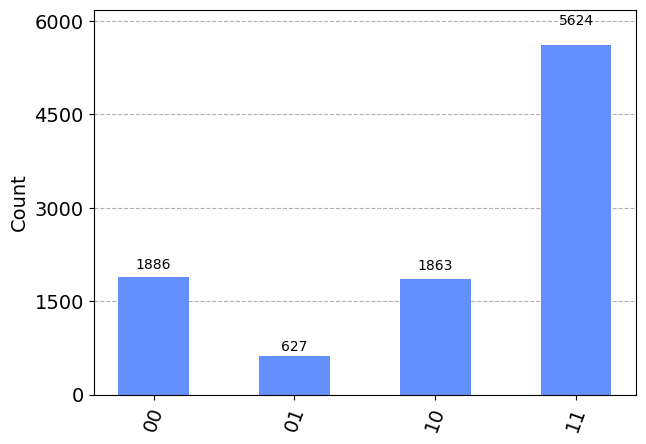

In [435]:
plot_histogram(counts)

In [436]:
counts

{'11': 5624, '00': 1886, '10': 1863, '01': 627}

In [437]:
x0_result = np.array((counts["01"]/ shots,counts["11"]/shots))
x0_result /= x0_result[0]

print("HHL result: ", np.sqrt(x0_result)*3/8)

HHL result:  [0.375      1.12310446]


In [438]:
display(Math("$\mathbf{x}: " + sp.latex(A1.solve(b1).T)))

<IPython.core.display.Math object>

Done

## Problem 2

In [445]:
from qiskit.circuit.library import CPhaseGate

In [446]:
y_theta2 = [2*np.arcsin(1/(2**i)) for i in range(0,4)]
U2_1 = U2
U2_2 = U2@U2
U2_3 = U2_2@U2_2
U2_4 = U2_3@U2_3
U2_1_inv = U2_inv
U2_2_inv = U2_1_inv@U2_1_inv
U2_3_inv = U2_2_inv@U2_2_inv
U2_4_inv = U2_3_inv@U2_3_inv

In [447]:
cu21     = UnitaryGate(U2_1, label="U21").control()
cu22     = UnitaryGate(U2_2, label="U22").control()
cu23     = UnitaryGate(U2_3, label="U23").control()
cu24     = UnitaryGate(U2_4, label="U24").control()
cu21_inv = UnitaryGate(U2_1_inv, label="U21_inv").control()
cu22_inv = UnitaryGate(U2_2_inv, label="U22_inv").control()
cu23_inv = UnitaryGate(U2_3_inv, label="U23_inv").control()
cu24_inv = UnitaryGate(U2_4_inv, label="U24_inv").control()

In [448]:
# System Configuration
num_ancilla_register = 1
num_clock_register = 4
num_vector_register = 2

In [449]:
# Quantum circuit register defintion
qr_ancilla2 = QuantumRegister(num_ancilla_register, name="ancilla")
qr_clock2 = QuantumRegister(num_clock_register, name="clock")
qr_vector2 = QuantumRegister(num_vector_register, name="vector")
cr2 = ClassicalRegister(3, name = "classic")

In [450]:
qc2 = QuantumCircuit(qr_ancilla2, qr_clock2, qr_vector2, cr2, name="HHL_2")

In [451]:
# Circuit configuration
qc2.h(qr_vector2) # Initiate b vector

qc2.barrier() # QPE initiate
qc2.h(qr_clock2)

qc2.append(cu21, [qr_clock2[0],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu22, [qr_clock2[1],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu23, [qr_clock2[2],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu24, [qr_clock2[3],  qr_vector2[0], qr_vector2[1]])

qc2.append(QFT(4).inverse(), qr_clock2[:])

qc2.barrier()
for i, angle in zip(range(0, len(qr_clock2)), y_theta2):
    qc2.cry(angle, qr_clock2[i], qr_ancilla2)

qc2.measure(qr_ancilla2, cr2[0])
qc2.barrier()
# QFT
qc2.append(QFT(4), qr_clock2[:])
#
qc2.append(cu24_inv, [qr_clock2[3],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu23_inv, [qr_clock2[2],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu22_inv, [qr_clock2[1],  qr_vector2[0], qr_vector2[1]])
qc2.append(cu21_inv, [qr_clock2[0],  qr_vector2[0], qr_vector2[1]])
qc2.barrier()
qc2.h(qr_clock2[:])
qc2.barrier()

In [452]:
qc2.draw()

░                                                ░ ┌───────┐»
  ancilla: ──────░────────────────────────────────────────────────░─┤ Ry(π) ├»
                 ░ ┌───┐                                ┌───────┐ ░ └───┬───┘»
  clock_0: ──────░─┤ H ├───■────────────────────────────┤0      ├─░─────■────»
                 ░ ├───┤   │                            │       │ ░          »
  clock_1: ──────░─┤ H ├───┼───────■────────────────────┤1      ├─░──────────»
                 ░ ├───┤   │       │                    │  IQFT │ ░          »
  clock_2: ──────░─┤ H ├───┼───────┼───────■────────────┤2      ├─░──────────»
                 ░ ├───┤   │       │       │            │       │ ░          »
  clock_3: ──────░─┤ H ├───┼───────┼───────┼───────■────┤3      ├─░──────────»
           ┌───┐ ░ └───┘┌──┴───┐┌──┴───┐┌──┴───┐┌──┴───┐└───────┘ ░          »
 vector_0: ┤ H ├─░──────┤0     ├┤0     ├┤0     ├┤0     ├──────────░──────────»
           ├───┤ ░      │  U21 ││  U22 ││  U23 ││  U24 │          ░          »
 vector_1: ┤ H ├─░──────┤1     ├┤1     ├┤1     ├┤1     ├──────────░──────────»
           └───┘ ░      └──────┘└──────┘└──────┘└──────┘          ░          »
classic: 3/══════════════════════════════════════════════════════════════════»
                                                                             »
«           ┌─────────┐┌─────────────┐┌─────────────┐┌─┐ ░                     »
«  ancilla: ┤ Ry(π/3) ├┤ Ry(0.50536) ├┤ Ry(0.25066) ├┤M├─░─────────────────────»
«           └────┬────┘└──────┬──────┘└──────┬──────┘└╥┘ ░ ┌──────┐            »
«  clock_0: ─────┼────────────┼──────────────┼────────╫──░─┤0     ├────────────»
«                │            │              │        ║  ░ │      │            »
«  clock_1: ─────■────────────┼──────────────┼────────╫──░─┤1     ├────────────»
«                             │              │        ║  ░ │  QFT │            »
«  clock_2: ──────────────────■──────────────┼────────╫──░─┤2     ├────────────»
«                                            │        ║  ░ │      │            »
«  clock_3: ─────────────────────────────────■────────╫──░─┤3     ├─────■──────»
«                                                     ║  ░ └──────┘┌────┴─────┐»
« vector_0: ──────────────────────────────────────────╫──░─────────┤0         ├»
«                                                     ║  ░         │  U24_inv │»
« vector_1: ──────────────────────────────────────────╫──░─────────┤1         ├»
«                                                     ║  ░         └──────────┘»
«classic: 3/══════════════════════════════════════════╩════════════════════════»
«                                                     0                        »
«                                                ░       ░ 
«  ancilla: ─────────────────────────────────────░───────░─
«                                                ░ ┌───┐ ░ 
«  clock_0: ─────────────────────────────■───────░─┤ H ├─░─
«                                        │       ░ ├───┤ ░ 
«  clock_1: ─────────────────■───────────┼───────░─┤ H ├─░─
«                            │           │       ░ ├───┤ ░ 
«  clock_2: ─────■───────────┼───────────┼───────░─┤ H ├─░─
«                │           │           │       ░ ├───┤ ░ 
«  clock_3: ─────┼───────────┼───────────┼───────░─┤ H ├─░─
«           ┌────┴─────┐┌────┴─────┐┌────┴─────┐ ░ └───┘ ░ 
« vector_0: ┤0         ├┤0         ├┤0         ├─░───────░─
«           │  U23_inv ││  U22_inv ││  U21_inv │ ░       ░ 
« vector_1: ┤1         ├┤1         ├┤1         ├─░───────░─
«           └──────────┘└──────────┘└──────────┘ ░       ░ 
«classic: 3/═══════════════════════════════════════════════
«

In [453]:
state_vector_sim = Aer.get_backend('statevector_simulator')

In [454]:
while True:
    result = execute(qc2, state_vector_sim, shots=1).result()
    counts = result.get_counts(qc2)
    if '001' in counts:
        break


In [455]:
state_vec_2 = result.get_statevector(decimals=3)

In [456]:
values = state_vec_2.data

In [457]:
state_vec_2

Statevector([ 0.   +0.j, -0.054-0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
             -0.   -0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j, -0.   -0.j,
              0.   +0.j,  0.   +0.j,  0.   +0.j, -0.   +0.j,  0.   +0.j,
              0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   +0.j,  0.   +0.j,
              0.   +0.j, -0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
              0.   -0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j, -0.   +0.j,
              0.   +0.j, -0.   +0.j,  0.   +0.j,  0.38 +0.j,  0.   +0.j,
              0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j, -0.   -0.j,
              0.   +0.j,  0.   -0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
             -0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   +0.j,  0.   -0.j,
              0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,  0.   +0.j,
              0.   +0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,  0.   -0.j,
              0.   +0.j,  0.   -0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
              0.597+0.j,  0.   +0.j,  0.   +0.j,  0

In [459]:
result_values = np.array([values[1], values[33], values[65], values[97]])

In [463]:
-result_values/result_values.min()

array([-1.        -0.j,  7.03703704-0.j, 11.05555556-0.j, 13.05555556-0.j])

In [461]:
np.abs(result_values)/np.abs(result_values).min()

array([ 1.        ,  7.03703704, 11.05555556, 13.05555556])

We get a solution. done